<a href="https://colab.research.google.com/github/clayedw/RET-2024/blob/main/alpha_beta_optimization_draft2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q condacolab
import condacolab

condacolab.install()

!conda install --no-pin pyccl
# Activate the conda environment where pyccl was installed
!conda activate base

import pyccl as ccl

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pyccl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    binutils_impl_linux-64-2.40|       hf600244_0         5.2 MB  conda-forge
    binutils_linux-64-2.40     |       hb3c18ed_9          29 KB  conda-forge
    brotli-1.1.0               |       hd590300_1          19 KB  conda-forge
    brotli

In this project, we aim to improve our understanding of the universe's large-scale structure by accurately estimating key cosmological parameters, specifically
Ω 𝑚  and 𝜎 8 . These parameters are crucial for describing the matter density and the amplitude of matter fluctuations in the universe, respectively.

To achieve this, we use a redshift distribution model parameterized by two variables, 𝛼 and
𝛽. The redshift distribution describes how galaxies are distributed across different redshifts, which is essential for studying the large-scale structure of the universe. Given the uncertainties in photometric redshift measurements, we need to account for these uncertainties by binning the redshift data appropriately.

We employ a Smail-type redshift distribution model characterized by parameters
𝛼 and
𝛽. To determine the best-fit values of these parameters, we explore different combinations of
𝛼 and
𝛽 values over specified ranges. For each combination, we account for photometric redshift uncertainties by scattering the redshift values and binning the data accordingly.

Next, we use a Markov Chain Monte Carlo (MCMC) method to estimate the cosmological parameters
Ω
𝑚
  and
𝜎
8 . The MCMC method allows us to explore the parameter space and find the values that maximize the likelihood of our model given the data. We use prior constraints based on our best-guess estimates of these parameters to guide the MCMC sampling.

We generate parameter maps for
Ω
𝑚
Ω
and
𝜎
8  across different
𝛼 β combinations for various photometric redshift uncertainties (
𝜎
𝑧
 ). These maps help us visualize the impact of
𝛼 and
𝛽 on the estimated cosmological parameters and identify the optimal values.

Finally, we determine the optimal
𝛼 and
𝛽 values as those that yield
Ω
𝑚
  and
𝜎
8  values closest to our best-guess estimates, taking into account the greater uncertainties of our simplified model. The resulting optimal parameter values provide insights into the redshift distribution and its impact on cosmological parameter estimation, contributing to our understanding of the universe's structure.








Optimal alpha: 1.0, Optimal beta: 1.0, Optimal sigma_z: 0.03


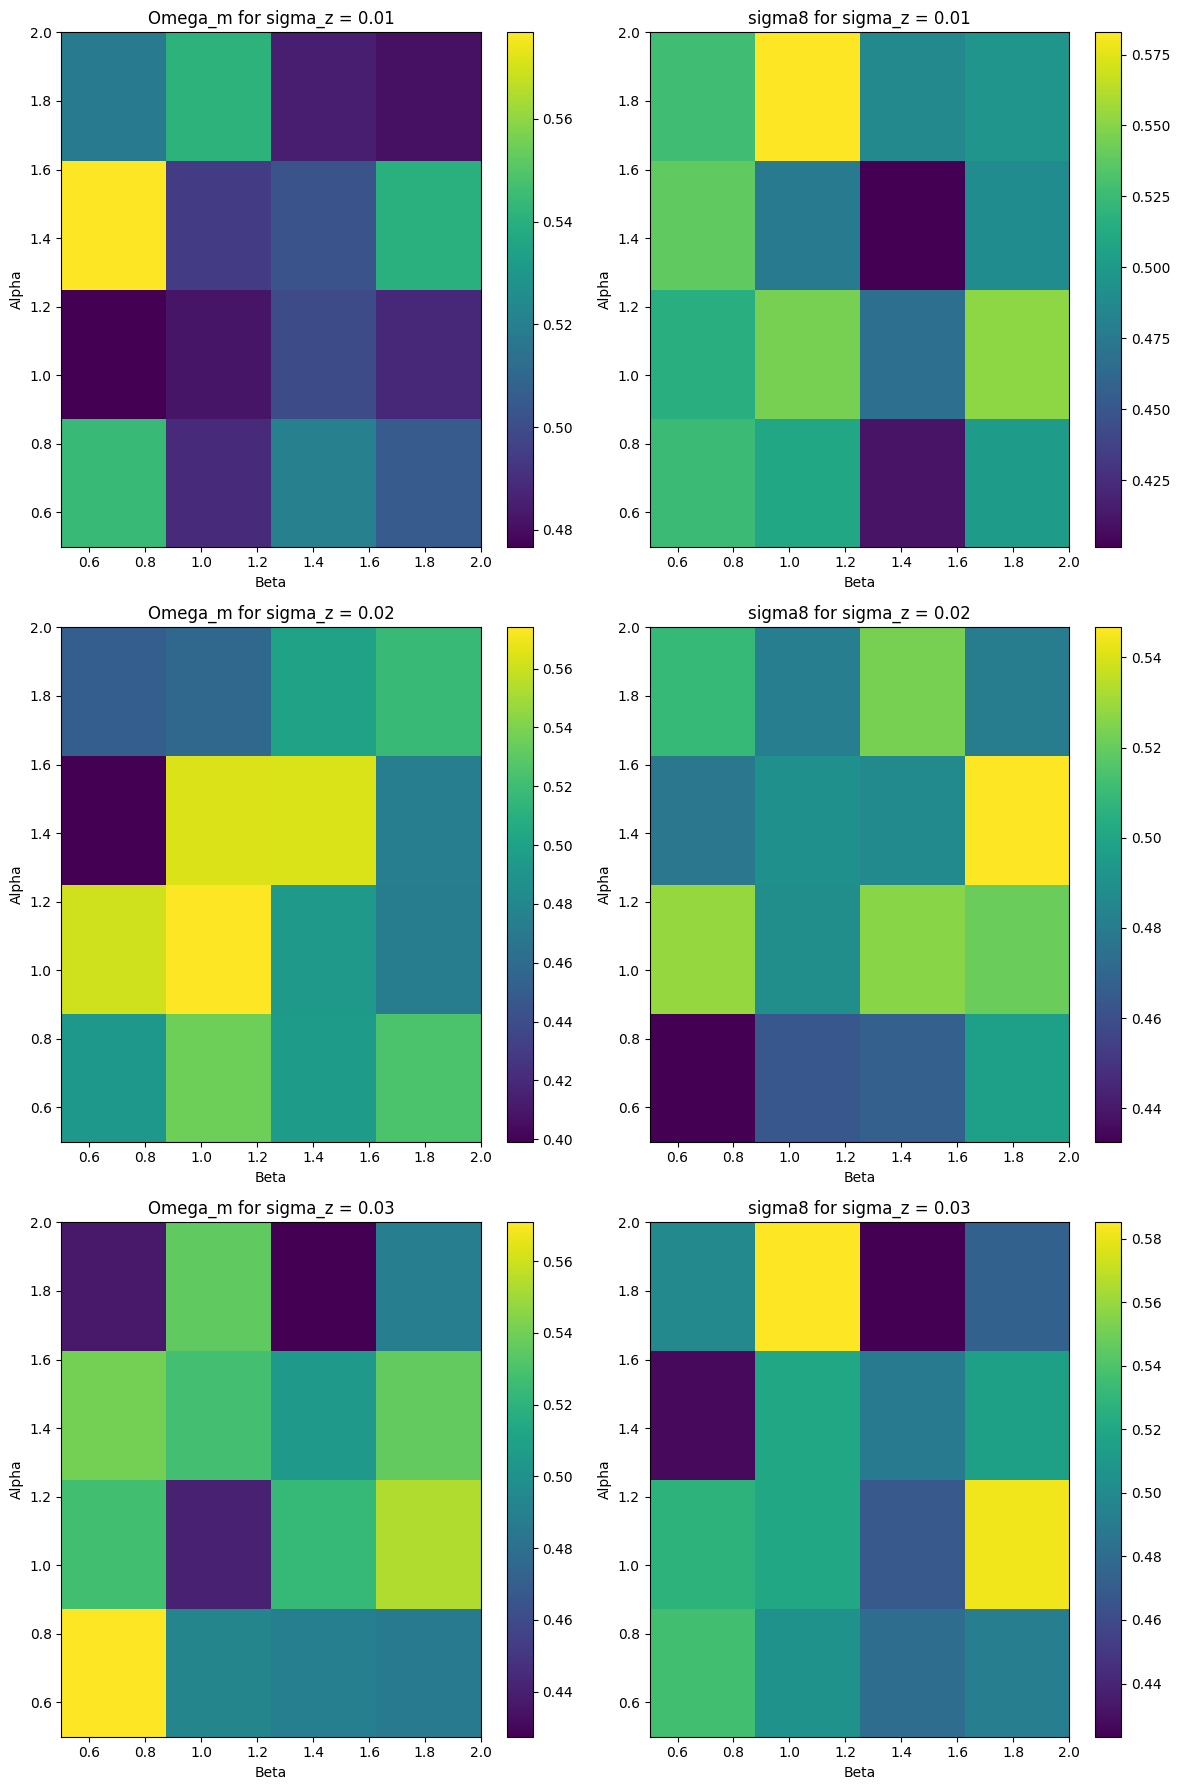

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.integrate import quad
from scipy.linalg import inv
import pyccl as ccl

class SRDRedshiftDistributions:
    def __init__(self, redshift_range):
        self.redshift_range = redshift_range

    def smail_type_distribution(self, pivot_redshift, alpha, beta):
        z_div_pivot = self.redshift_range / pivot_redshift
        redshift_distribution = z_div_pivot ** beta * np.exp(-(z_div_pivot) ** alpha)
        return redshift_distribution

class RedshiftBinning:
    def __init__(self, redshifts, redshift_dist, bin_edges, uncertainties):
        self.redshifts = redshifts
        self.redshift_dist = redshift_dist
        self.bin_edges = bin_edges
        self.uncertainties = uncertainties
        self.binned_distribution = np.zeros((len(bin_edges) - 1, len(redshifts)))

    def gaussian_contribution(self, z_i, sigma, bin_edge1, bin_edge2):
        norm_factor = 1 / (sigma * np.sqrt(2 * np.pi))
        integrand = lambda x: norm_factor * np.exp(-0.5 * ((x - z_i) / sigma) ** 2)
        contribution, _ = quad(integrand, bin_edge1, bin_edge2)
        return contribution

    def bin_data(self, scatter):
        for i, z in enumerate(self.redshifts):
            for j in range(len(self.bin_edges) - 1):
                bin_edge1 = self.bin_edges[j]
                bin_edge2 = self.bin_edges[j + 1]
                z_scattered = z + scatter[i]
                self.binned_distribution[j, i] = self.redshift_dist[i] * self.gaussian_contribution(z_scattered, self.uncertainties[i], bin_edge1, bin_edge2)

        # Normalize the binned distribution
        self.binned_distribution /= self.binned_distribution.sum(axis=1)[:, None]

# Define cosmological parameters
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Angular multipoles
ell = np.arange(2, 2000)

# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Calculate the correlation function for each bin with true redshift distribution
def compute_true_correlations(bin_edges, redshift_range, true_lens_redshift_distribution_dict):
    true_tracers = []
    for i in range(len(bin_edges) - 1):
        z_bin = redshift_range
        dNdz = true_lens_redshift_distribution_dict[i]
        tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz), bias=(z_bin, np.full_like(z_bin, 1.5)))
        true_tracers.append(tracer)

    true_cls_matrix = np.zeros((len(bin_edges) - 1, len(ell)))
    for i in range(len(bin_edges) - 1):
        true_cls_matrix[i] = ccl.angular_cl(cosmo, true_tracers[i], true_tracers[i], ell)

    true_correlations_matrix = np.zeros((len(bin_edges) - 1, len(theta_deg)))
    for i in range(len(bin_edges) - 1):
        true_cls = true_cls_matrix[i]
        true_correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=true_cls, theta=theta_deg, type='NN', method='FFTLog')

    return true_correlations_matrix

# Function to compute Omega_m and sigma8 for given alpha, beta, and photoz uncertainty
def compute_omega_sigma(alpha, beta, sigma_z, covariance_matrix, true_correlations_matrix):
    # Calculate redshift distribution with given alpha and beta
    redshift_range = np.linspace(0.2, 1.2, 512)
    pivot_redshift = 0.26
    srd_dist = SRDRedshiftDistributions(redshift_range)
    redshift_distribution = srd_dist.smail_type_distribution(pivot_redshift, alpha, beta)

    # Define bin edges and sigma (uncertainty)
    bin_edges = np.linspace(0.2, 1.2, 6)
    sigma = sigma_z * np.ones_like(redshift_range)

    # Calculate scatter
    scatter = sigma_z * (1 + redshift_range)

    # Instantiate RedshiftBinning and bin the data
    binning = RedshiftBinning(redshift_range, redshift_distribution, bin_edges, sigma)
    binning.bin_data(scatter)

    # Create NumberCountsTracers for each bin using the binned redshift distribution
    tracers = []
    for i in range(len(bin_edges) - 1):
        z_bin = redshift_range
        dNdz_bin = binning.binned_distribution[i]
        tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, np.full_like(z_bin, 1.5)))
        tracers.append(tracer)

    # Calculate angular power spectra
    cls = [ccl.angular_cl(cosmo, tracer, tracer, ell) for tracer in tracers]

    # Define likelihood function
    def ln_likelihood(theta):
        Omega_m, sigma8 = theta
        ln_likelihood_total = 0.0

        # Loop over each bin and compute likelihood contribution
        for i in range(len(bin_edges) - 1):
            xi_true = true_correlations_matrix[i]
            xi_model = ccl.correlation(cosmo, ell=ell, C_ell=cls[i], theta=theta_deg, type='NN', method='FFTLog')
            diff = xi_true - xi_model
            chi2 = diff.T @ inv(covariance_matrix) @ diff
            ln_likelihood_total += -0.5 * chi2

        return ln_likelihood_total

    # MCMC setup
    ndim = 2  # Number of parameters (Omega_m, sigma8)
    nwalkers = 50  # Number of walkers
    p0 = np.random.rand(nwalkers, ndim)  # Random initial positions in parameter space

    # Define prior function
    def ln_prior(theta):
        Omega_m, sigma8 = theta
        if 0.267 - 0.03 < Omega_m < 0.267 + 0.03 and 0.762 - 0.03 < sigma8 < 0.762 + 0.03:
            return 0.0
        return -np.inf

    # Define combined log-probability function
    def ln_prob(theta):
        lp = ln_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + ln_likelihood(theta)

    # Initialize sampler and run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob)
    pos, prob, state = sampler.run_mcmc(p0, 100)
    sampler.reset()
    sampler.run_mcmc(pos, 1000)

    # Extract samples
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

    # Compute mean and standard deviation of parameters
    Omega_m_mean, sigma8_mean = np.mean(samples, axis=0)
    Omega_m_std, sigma8_std = np.std(samples, axis=0)

    # Compute the deviation from target values
    Omega_m_target = 0.267
    sigma8_target = 0.762
    deviation = np.sqrt((Omega_m_mean - Omega_m_target) ** 2 + (sigma8_mean - sigma8_target) ** 2)

    return Omega_m_mean, Omega_m_std, sigma8_mean, sigma8_std, deviation

# Example usage
alpha_range = [0.5, 1.0, 1.5, 2.0]
beta_range = [0.5, 1.0, 1.5, 2.0]
sigma_z_values = [0.01, 0.02, 0.03]

covariance_matrix = np.identity(len(theta_deg))  # Example identity matrix for covariance

true_lens_redshift_distribution_dict = {i: np.ones_like(np.linspace(0.2, 1.2, 512)) for i in range(5)}  # Placeholder
bin_edges = np.linspace(0.2, 1.2, 6)
true_correlations_matrix = compute_true_correlations(bin_edges, np.linspace(0.2, 1.2, 512), true_lens_redshift_distribution_dict)

results = {}

for alpha in alpha_range:
    for beta in beta_range:
        for sigma_z in sigma_z_values:
            omega_m_mean, omega_m_std, sigma8_mean, sigma8_std, deviation = compute_omega_sigma(alpha, beta, sigma_z, covariance_matrix, true_correlations_matrix)
            results[(alpha, beta, sigma_z)] = (omega_m_mean, omega_m_std, sigma8_mean, sigma8_std, deviation)

# Find the optimal parameters
optimal_params = min(results, key=lambda x: results[x][-1])
optimal_alpha, optimal_beta, optimal_sigma_z = optimal_params
print(f'Optimal alpha: {optimal_alpha}, Optimal beta: {optimal_beta}, Optimal sigma_z: {optimal_sigma_z}')

# Plotting
fig, axes = plt.subplots(len(sigma_z_values), 2, figsize=(12, len(sigma_z_values) * 6))

for i, sigma_z in enumerate(sigma_z_values):
    omega_m_values = np.zeros((len(alpha_range), len(beta_range)))
    sigma8_values = np.zeros((len(alpha_range), len(beta_range)))

    for j, alpha in enumerate(alpha_range):
        for k, beta in enumerate(beta_range):
            omega_m_mean, omega_m_std, sigma8_mean, sigma8_std, _ = results[(alpha, beta, sigma_z)]
            omega_m_values[j, k] = omega_m_mean
            sigma8_values[j, k] = sigma8_mean

    ax1 = axes[i, 0]
    ax2 = axes[i, 1]

    c1 = ax1.imshow(omega_m_values, extent=[beta_range[0], beta_range[-1], alpha_range[0], alpha_range[-1]], origin='lower', aspect='auto')
    fig.colorbar(c1, ax=ax1)
    ax1.set_title(f'Omega_m for sigma_z = {sigma_z}')
    ax1.set_xlabel('Beta')
    ax1.set_ylabel('Alpha')

    c2 = ax2.imshow(sigma8_values, extent=[beta_range[0], beta_range[-1], alpha_range[0], alpha_range[-1]], origin='lower', aspect='auto')
    fig.colorbar(c2, ax=ax2)
    ax2.set_title(f'sigma8 for sigma_z = {sigma_z}')
    ax2.set_xlabel('Beta')
    ax2.set_ylabel('Alpha')

plt.tight_layout()
plt.show()
